# Parameterization training and ensemble runs

In [1]:
%load_ext line_profiler

In [3]:
import notebook_utils

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.optimize as opt
import numpy.polynomial.polynomial as poly
import os
from pathlib import Path
import matplotlib.colors as mcolors

import flags

from models.lorenz96_model import L96, L96_2t_x_dot_y_dot_solver

from utils.saving_and_loading import save_output_l96, save_output_gcm, save_output_ensemble, save_output_l96_ensemble_simulation

In [4]:
output_folder = 'output'
figures_folder  = 'output/figures'
Path(figures_folder).mkdir(parents=True, exist_ok=True)

In [5]:
dpi = 150
save_plots = False

Define parameters according to Arnold et al. 2013.

In [59]:

FLAGS = flags.Flags({
    'K': 8,  # Number of global-scale variables X
    'J': 32,  # Number of local-scale Y variables per single global-scale X variable
    'h': 1.0,  # Coupling coefficient
    'F': 20.0,  # Forcing
    'b': 10.0,  # spatial-scale ratio
    # time-scale ratio, 4 (small time-scale separation, hard) or 10 (large time-scale separation, easy)
    'c': 10.0,
})

In [60]:
FLAGS['seed'] = 17

## Truth simulation: Two time-scale L96

In [61]:
FLAGS['method'] = 'manual'
FLAGS['si'] = 0.1
FLAGS['dt'] = 0.001
FLAGS['t_total'] = 5000 
FLAGS['train_perc'] = 0.1

In [62]:
m = L96(FLAGS['K'], FLAGS['J'], FLAGS['F'],
                     FLAGS['h'], FLAGS['b'], FLAGS['c'], seed=FLAGS['seed'])
# Spin up model for 3 days
# `store=True` saves the final state as an initial condition for the next run.
m.run(si=FLAGS['si'], t_total=10, store=True, method=FLAGS['method'])
init_conditions = m.x

In [63]:
init_conditions.dtype

dtype('float64')

In [64]:
# Run the model and return the true coupling term u
x_true, y_true, t, u = \
    m.run(FLAGS['si'], FLAGS['t_total'], dt=FLAGS['dt'],
          method=FLAGS['method'], store=True, return_coupling=True)

In [65]:
save_output_l96(output_folder, FLAGS, x_true, y_true, t, u)

### Plots

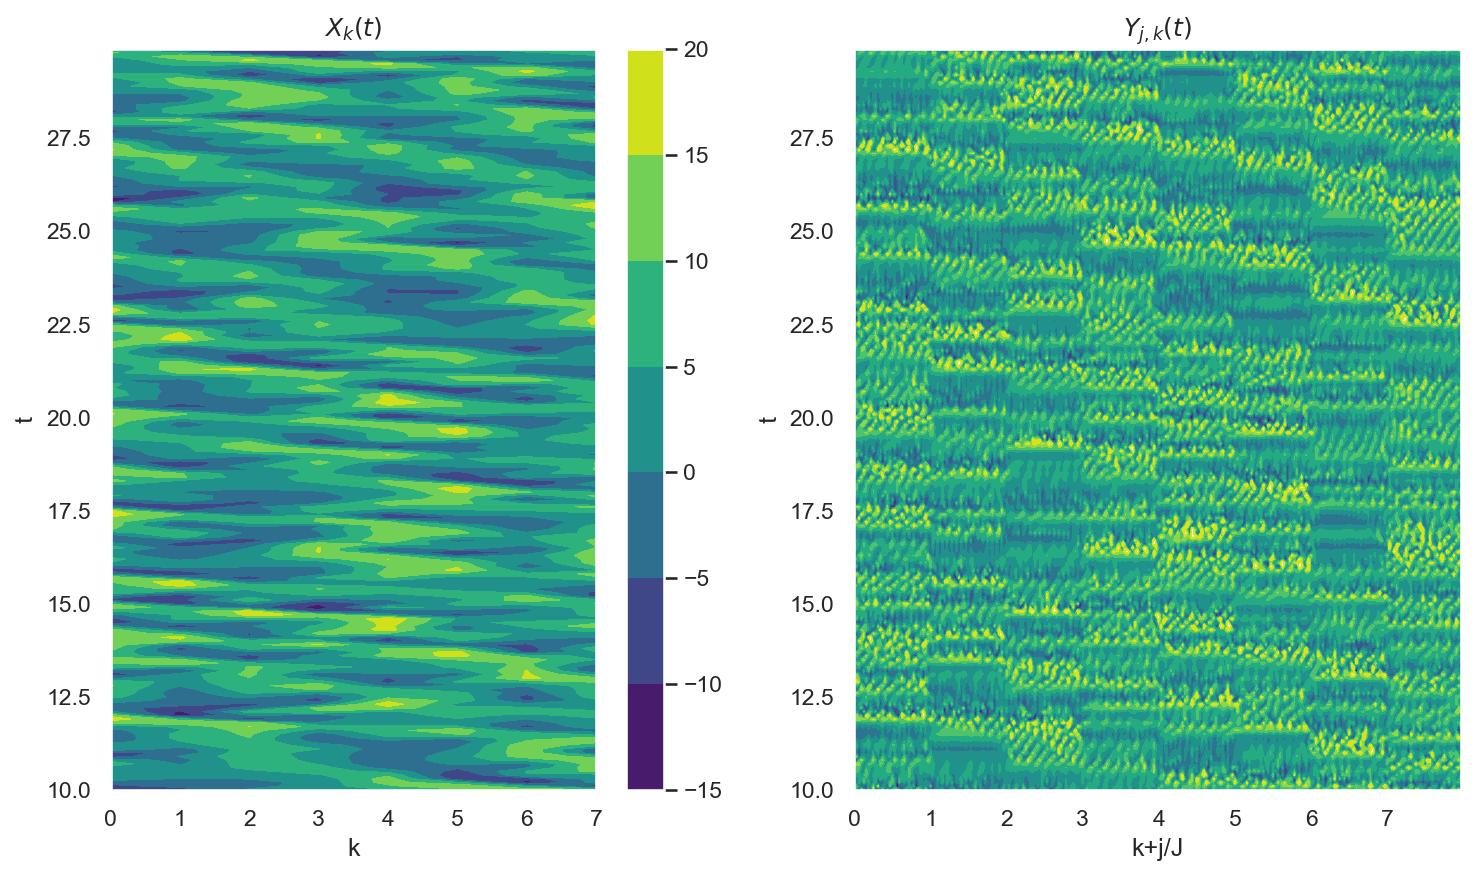

In [13]:
time_i = 200

cmap = 'viridis'

sns.set_theme()
plt.figure(figsize=(10, 6), dpi=dpi)

plt.subplot(121)  # nrows, ncols, index
plt.contourf(m.range_k, t[:time_i], x_true[:time_i, :], cmap=cmap)
plt.colorbar()
plt.xlabel("k")
plt.ylabel("t")
plt.title("$X_k(t)$")

plt.subplot(122)
plt.contourf(m.range_jk / m.j,
             t[:time_i], y_true[:time_i, :], levels=np.linspace(-1, 1, 10),  cmap=cmap)
plt.xlabel("k+j/J")
plt.ylabel("t")
plt.title("$Y_{j,k}(t)$")

plt.tight_layout()

if save_plots: 
    f_name = f"l96_training2d_c{FLAGS['c']}_dt{FLAGS['dt']}_si{FLAGS['si']}_time{FLAGS['t_total']}.pdf"
    plt.savefig(os.path.join(figures_folder, f_name), format="pdf", bbox_inches="tight")

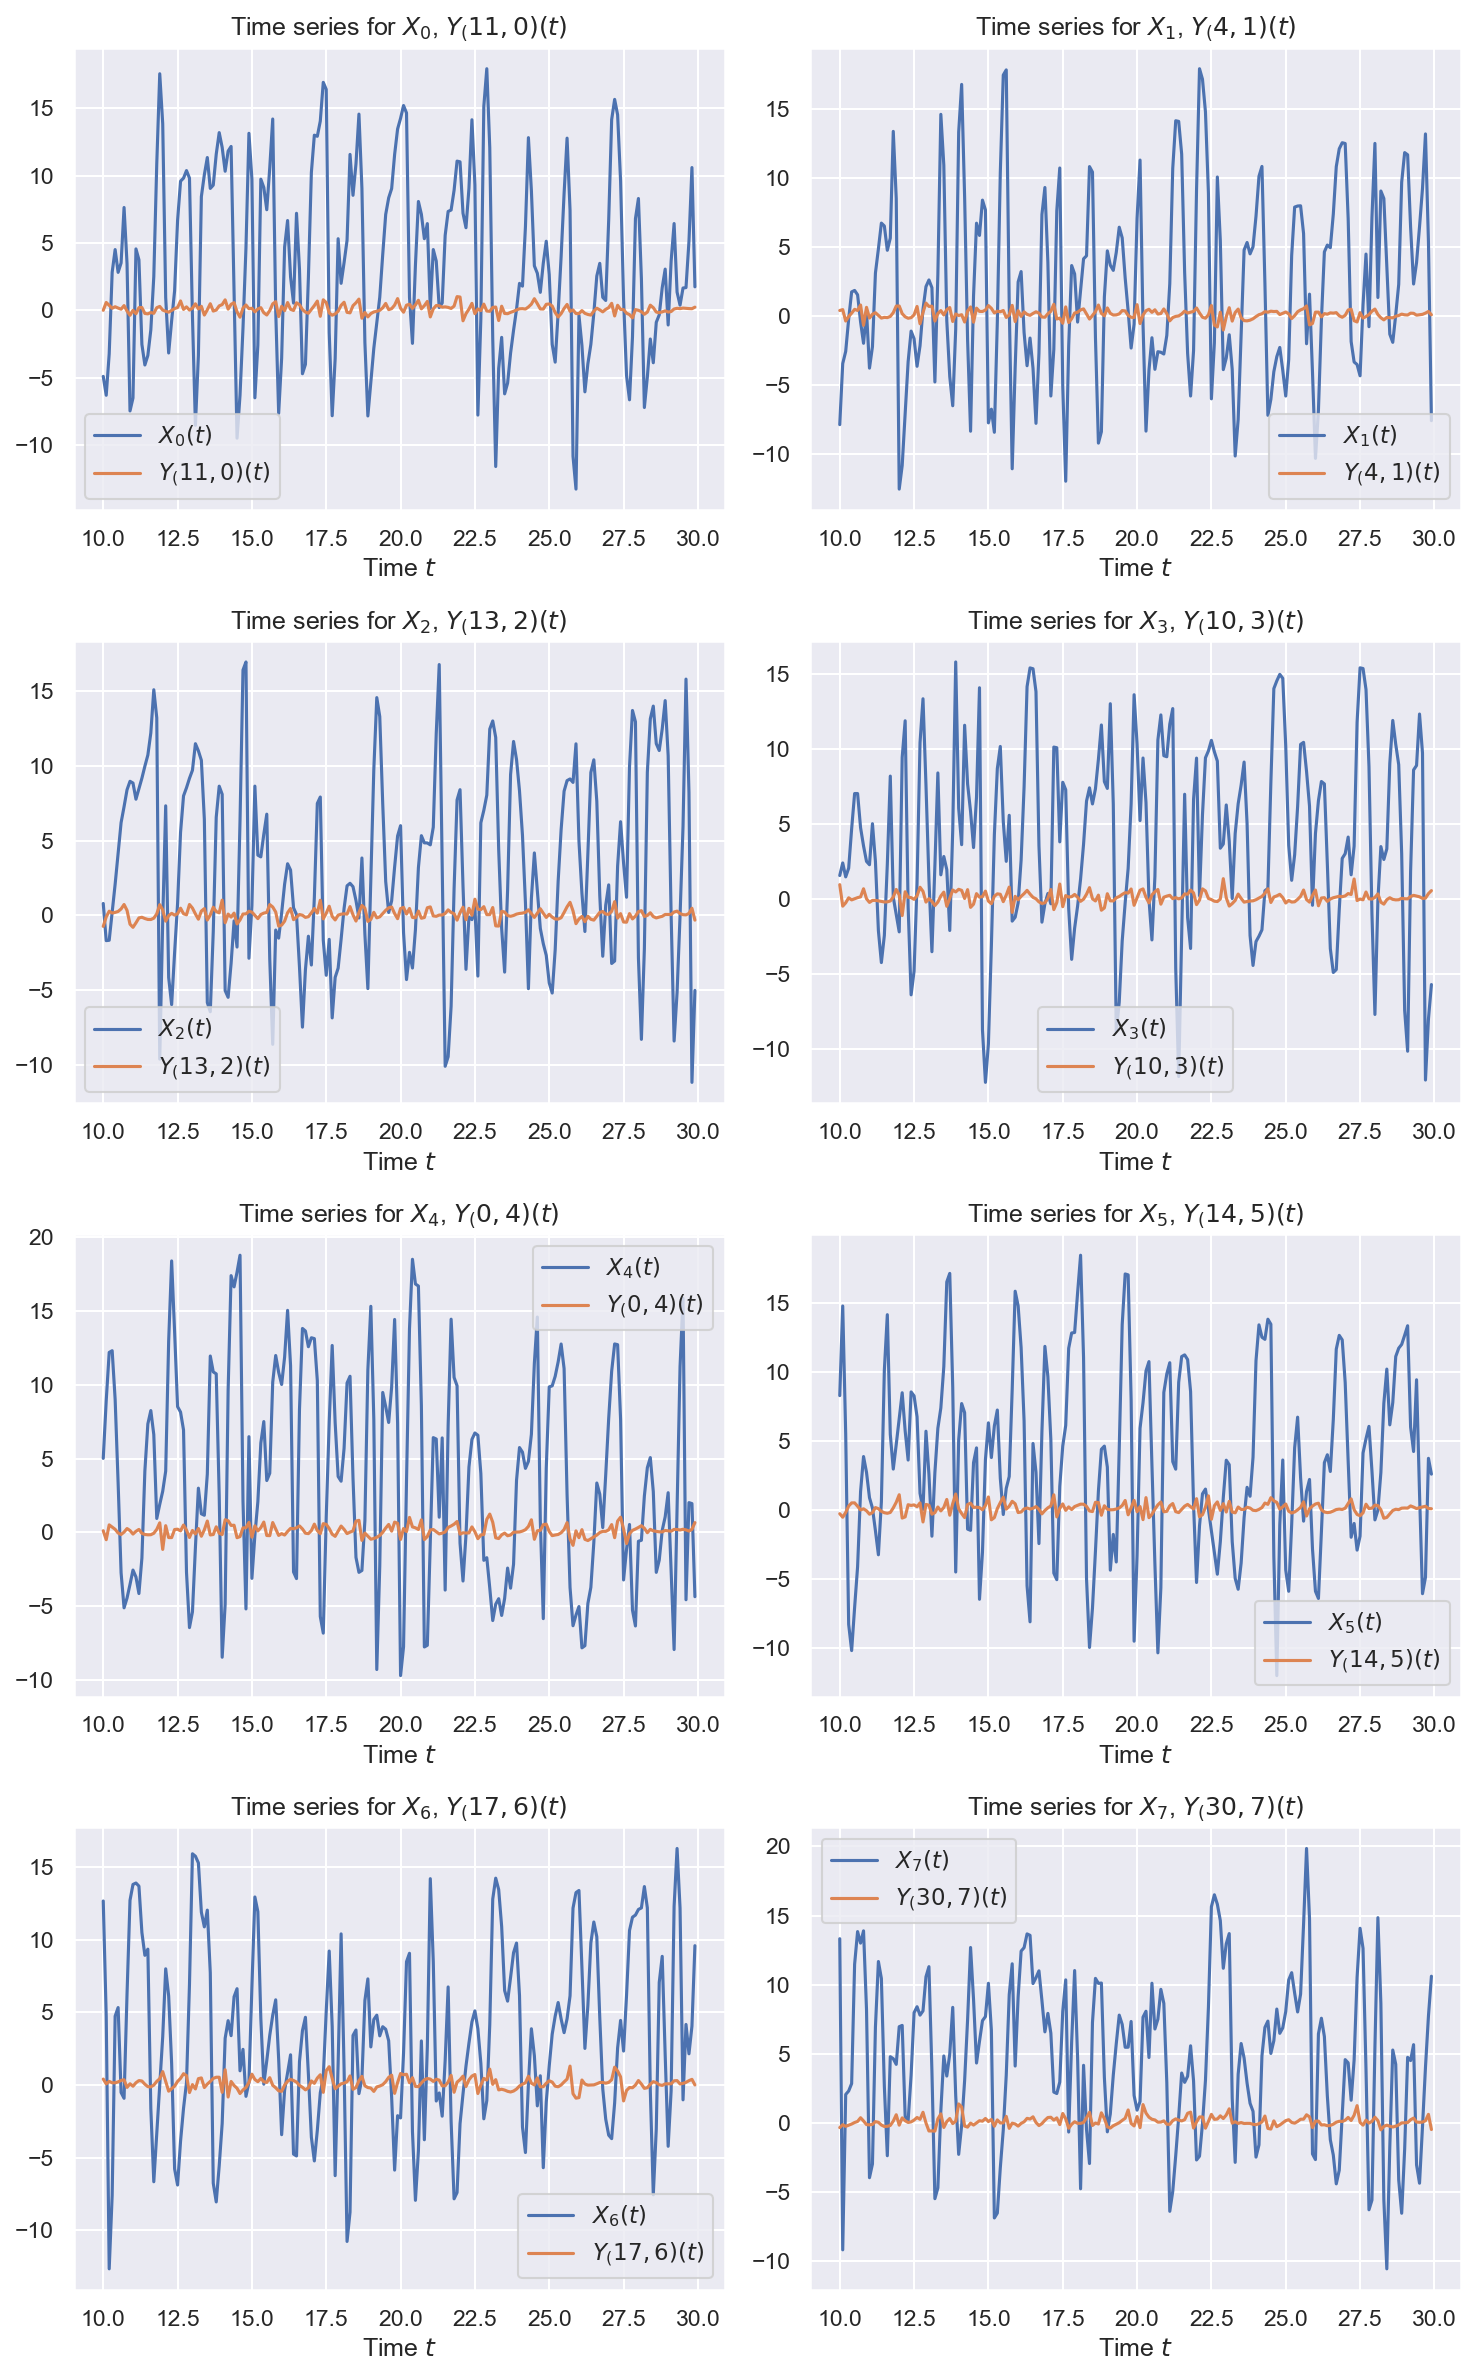

In [14]:
sns.set_theme()

# plot each x_k
plt.figure(figsize=(10, FLAGS['K'] * 2), dpi=dpi)
for i in range(FLAGS['K']):

    subplot_index = int(f"{math.ceil(FLAGS['K']/2)}2{i+1}")
    plt.subplot(subplot_index)

    random_y_index = np.random.randint(0, FLAGS['J'])
    plt.plot(t[:time_i], x_true[:time_i, i], label=f"$X_{i}(t)$")
    plt.plot(t[:time_i], y_true[:time_i, i],
             label=f"$Y_{random_y_index, i}(t)$")
    plt.xlabel("Time $t$")
    plt.title(f"Time series for $X_{i}$, $Y_{random_y_index, i}(t)$")
    plt.legend()

plt.tight_layout()

if save_plots:
    f_name = f"l96_training_time_series_c{FLAGS['c']}_dt{FLAGS['dt']}_si{FLAGS['si']}_time{FLAGS['t_total']}.pdf"
    plt.savefig(os.path.join(figures_folder, f_name),
                format="pdf", bbox_inches="tight")

### Select training data

In [66]:
train_index = int(FLAGS['train_perc'] * x_true.shape[0])

x_train, y_train, t_train, u_train = x_true[:501], y_true[:501], t[:501], u[:501]
x_train.shape

(501, 8)

## Deterministic parameterization

$U_p$ = Polynomial of order 3 (analogue to Arnold et al. 2013)

In [67]:
p3_coefs = poly.polyfit(x_train.flatten(), u_train.flatten(), 3)

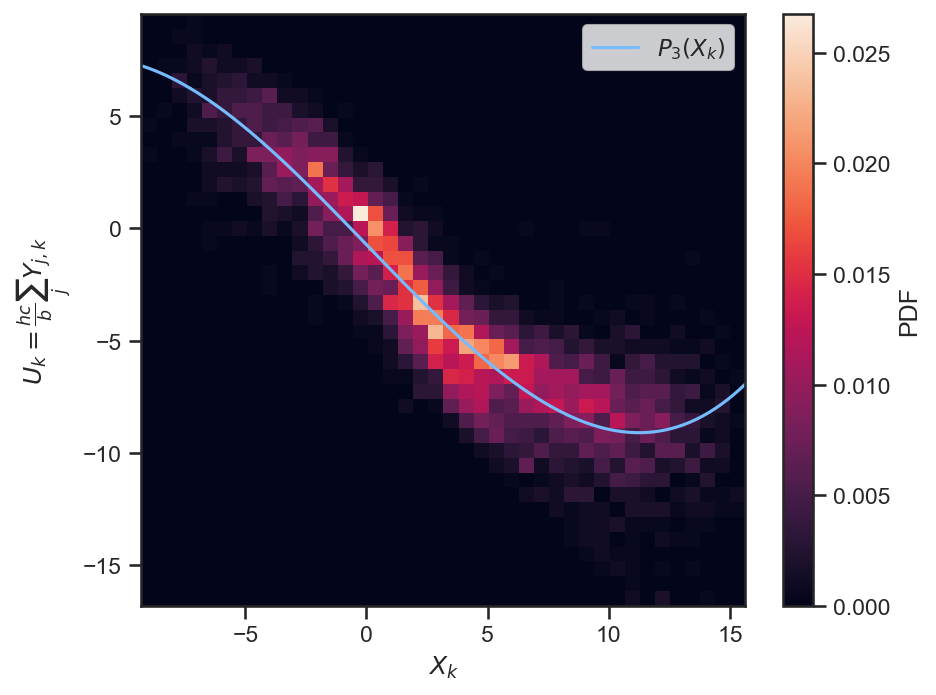

In [68]:
sns.set_theme(style='ticks', palette='rocket', color_codes=True)

# plot fit
plt.figure(dpi=dpi)

# 2D histogram of X vs U
plt.hist2d(x_train.flatten(), u_train.flatten(), bins=40, density=True, cmap='rocket')
plt.xlabel("$X_k$")
plt.ylabel(r"$U_k = \frac{hc}{b}\sum_j Y_{j,k}$")
plt.colorbar(label="PDF")

# Fits from polynomials
plot_x = np.linspace(x_train.flatten().min(), x_train.flatten().max(), 100)
plt.plot(plot_x, poly.polyval(plot_x, p3_coefs), color='xkcd:sky blue', label="$P_3(X_k)$")

plt.legend()

plt.tight_layout()

if save_plots:
    f_name = f"det_param_fit_c{FLAGS['c']}_dt{FLAGS['dt']}_si{FLAGS['si']}_time{FLAGS['t_total']}.pdf"
    plt.savefig(os.path.join(figures_folder, f_name), format="pdf", bbox_inches="tight")

## Stochastic parameterization

Analogue to Arnold et al. 2013:

$U_p = U_{det} + e(t)$

Model $e(t)$ as a first-order autoregressive (AR(1)) process: 

$e(t) = \phi e(t-\Delta t) + \sigma_e (1 - \phi^2)^{1/2} z(t)$

### Residuals

In [69]:
residuals = u_train - poly.polyval(x_train, p3_coefs) # y_data
residuals.shape

(501, 8)

In [70]:
time_idx = np.arange(0, residuals.shape[0], dtype=int) 
time_idx.shape

(501,)

### Fit with scipy.curve_fit

In [5]:
from parameterization.ar1_noise import fit_ar1_noise_parameters, compute_ar1_noise

In [72]:
phi, sigma_e, phi_cov, sigma_e_cov = fit_ar1_noise_parameters(residuals, seed=FLAGS['seed'])
phi.shape

(8,)

In [73]:
ar1_noise = compute_ar1_noise(phi, sigma_e, residuals.shape[0], seed=FLAGS['seed'])

### Plots

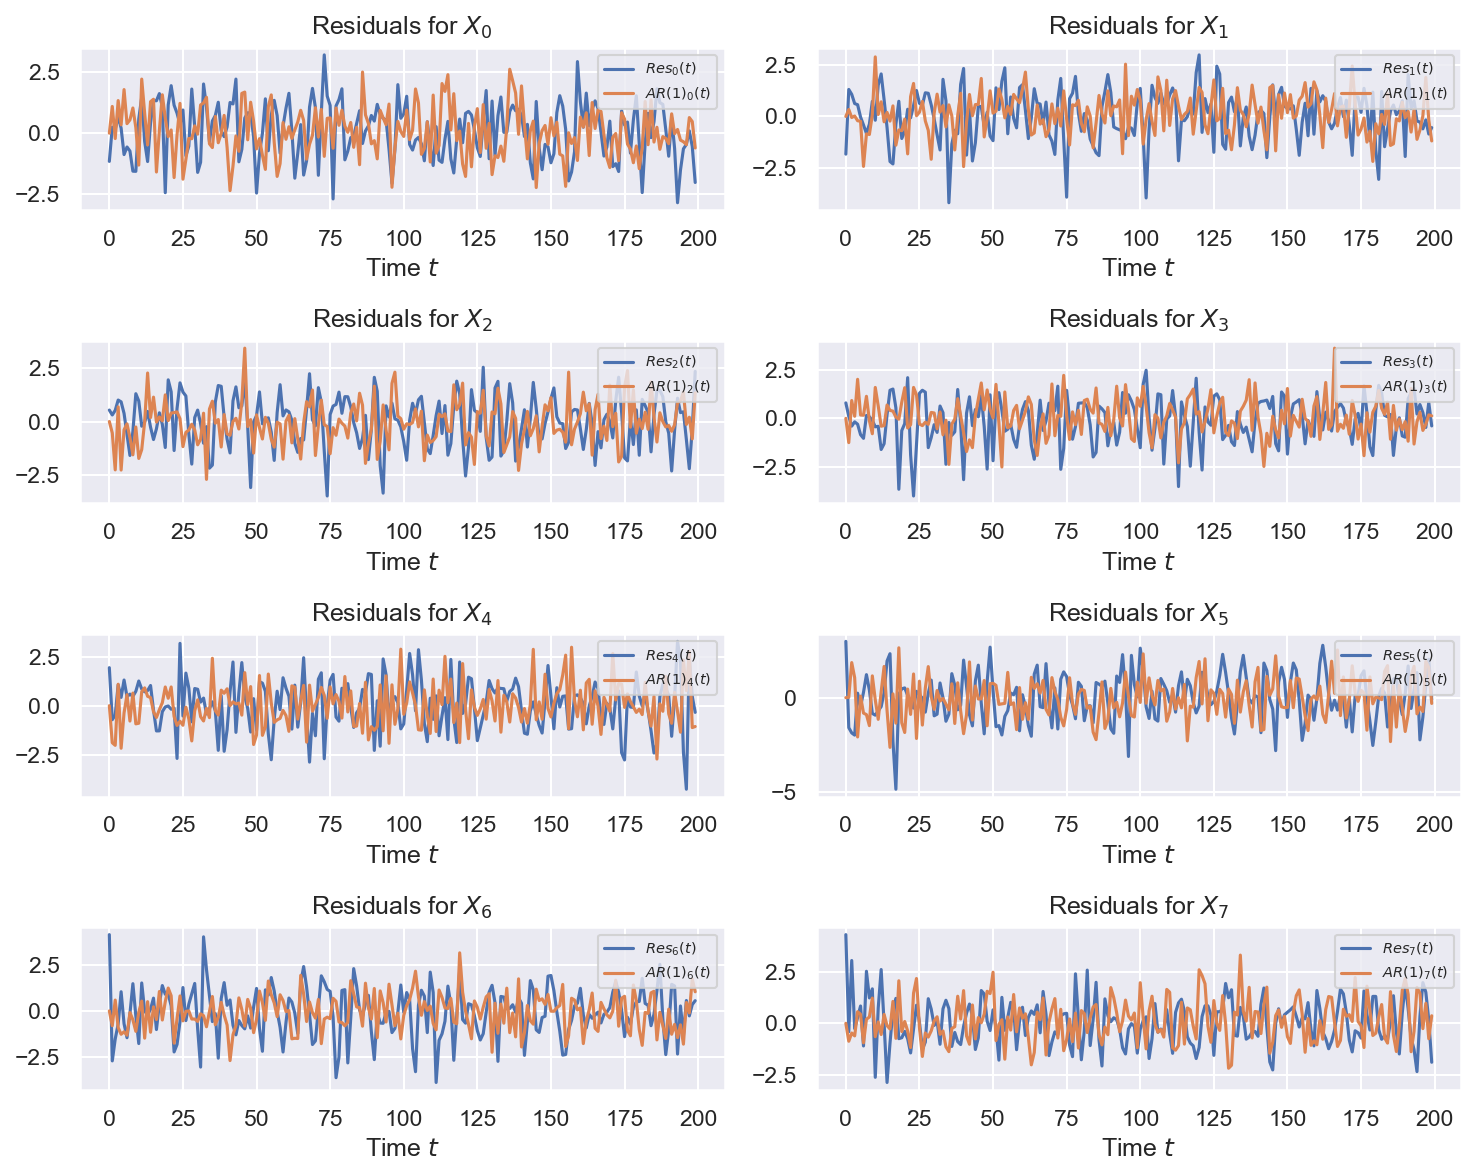

In [23]:
# control
sns.set_theme()

# plot residuals and autoregessive noise for each x_k
plt.figure(figsize=(10, FLAGS['K']), dpi=dpi)
for i in range(FLAGS['K']):
    # new subplot:
    # nrows = math.ceil(FLAGS['K']/2) (2 plots in each row),
    # ncols = 2,
    # index = i
    subplot_index = int(f"{math.ceil(FLAGS['K']/2)}2{i+1}")
    plt.subplot(subplot_index)

    plt.plot(time_idx[:time_i], residuals[:time_i, i], label=f"$Res_{i}(t)$")
    plt.plot(time_idx[:time_i], ar1_noise[:time_i, i], label=f"$AR(1)_{i}(t)$")
    plt.xlabel("Time $t$")
    plt.title(f"Residuals for $X_{i}$")
    plt.legend(fontsize=7, loc='upper right')

plt.tight_layout()

if save_plots: 
    f_name = f"residuals_ar1_c{FLAGS['c']}_dt{FLAGS['dt']}_si{FLAGS['si']}_time{FLAGS['t_total']}_rs{FLAGS['seed']}.pdf"
    plt.savefig(os.path.join(figures_folder, f_name), format="pdf", bbox_inches="tight")


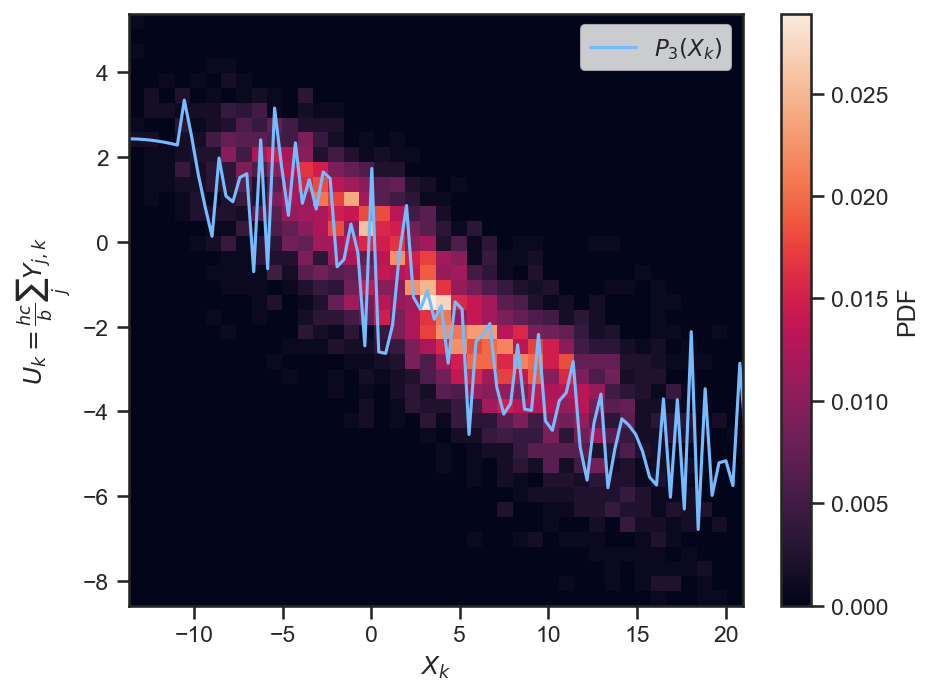

In [30]:
sns.set_theme(style='ticks', palette='rocket', color_codes=True)

# plot fit
plt.figure(dpi=dpi)


# 2D histogram of X vs U
plt.hist2d(x_train.flatten(), u_train.flatten(),
           bins=40, density=True, cmap='rocket')
plt.xlabel("$X_k$")
plt.ylabel(r"$U_k = \frac{hc}{b}\sum_j Y_{j,k}$")
plt.colorbar(label="PDF")

poly.polyval(x_train, p3_coefs)
ar1_noise_plot = compute_ar1_noise(
    phi, sigma_e, poly.polyval(x_train, p3_coefs).shape[0], seed=FLAGS['seed'])

plot_x = np.linspace(x_train.flatten().min(), x_true.flatten().max(), 100)

plt.plot(plot_x, poly.polyval(plot_x, p3_coefs) + ar1_noise_plot.flatten()
         [:poly.polyval(plot_x, p3_coefs).shape[0]], color='xkcd:sky blue', label="$P_3(X_k)$")

plt.tight_layout()
plt.legend()

if save_plots:
    f_name = f"stoch_param_fit_c{FLAGS['c']}_dt{FLAGS['dt']}_si{FLAGS['si']}_time{FLAGS['t_total']}_rs{FLAGS['seed']}.pdf"
    plt.savefig(os.path.join(figures_folder, f_name),
                format="pdf", bbox_inches="tight")

## GCM run with parameterization

In [6]:
from models.gcm_models import GCM, GCMManual
from parameterization.stochastic_poly_parameterization import PolynomialAR1Parameterization

### Without parameterization

In [32]:
FLAGS['t_total'] = 5000 

In [33]:
gcm_no_param = GCMManual(FLAGS['F'])
x_no_param, t_no_param = gcm_no_param(
    init_conditions, si=FLAGS['si'], t_total=FLAGS['t_total'], dt=FLAGS['dt'])

In [34]:
save_output_gcm(output_folder, FLAGS, 'no_param', x_no_param, t_no_param)

### Deterministic parameterization 

In [35]:
det_param = lambda x:  poly.polyval(x, p3_coefs)

In [36]:
gcm_det_param = GCMManual(FLAGS['F'], det_param)
x_det_param, t_det_param = gcm_det_param(
    init_conditions, si=FLAGS['si'], t_total=FLAGS['t_total'], dt=FLAGS['dt'])

In [37]:
save_output_gcm(output_folder, FLAGS, 'det_param',  x_det_param, t_det_param)


### Stochastic parameterization

In [38]:
stochastic_param = PolynomialAR1Parameterization(p3_coefs, phi, sigma_e, seed=FLAGS['seed'])

In [39]:
gcm_stoch_param = GCMManual(FLAGS['F'], stochastic_param)

%time x_stoch_param, t_stoch_param = gcm_stoch_param( \
    init_conditions, si=FLAGS['si'], t_total=FLAGS['t_total'], dt=FLAGS['dt'])

CPU times: user 2min 33s, sys: 416 ms, total: 2min 33s
Wall time: 2min 34s


In [40]:
save_output_gcm(output_folder, FLAGS, 'stoch_param', x_stoch_param, t_stoch_param)


### Plots

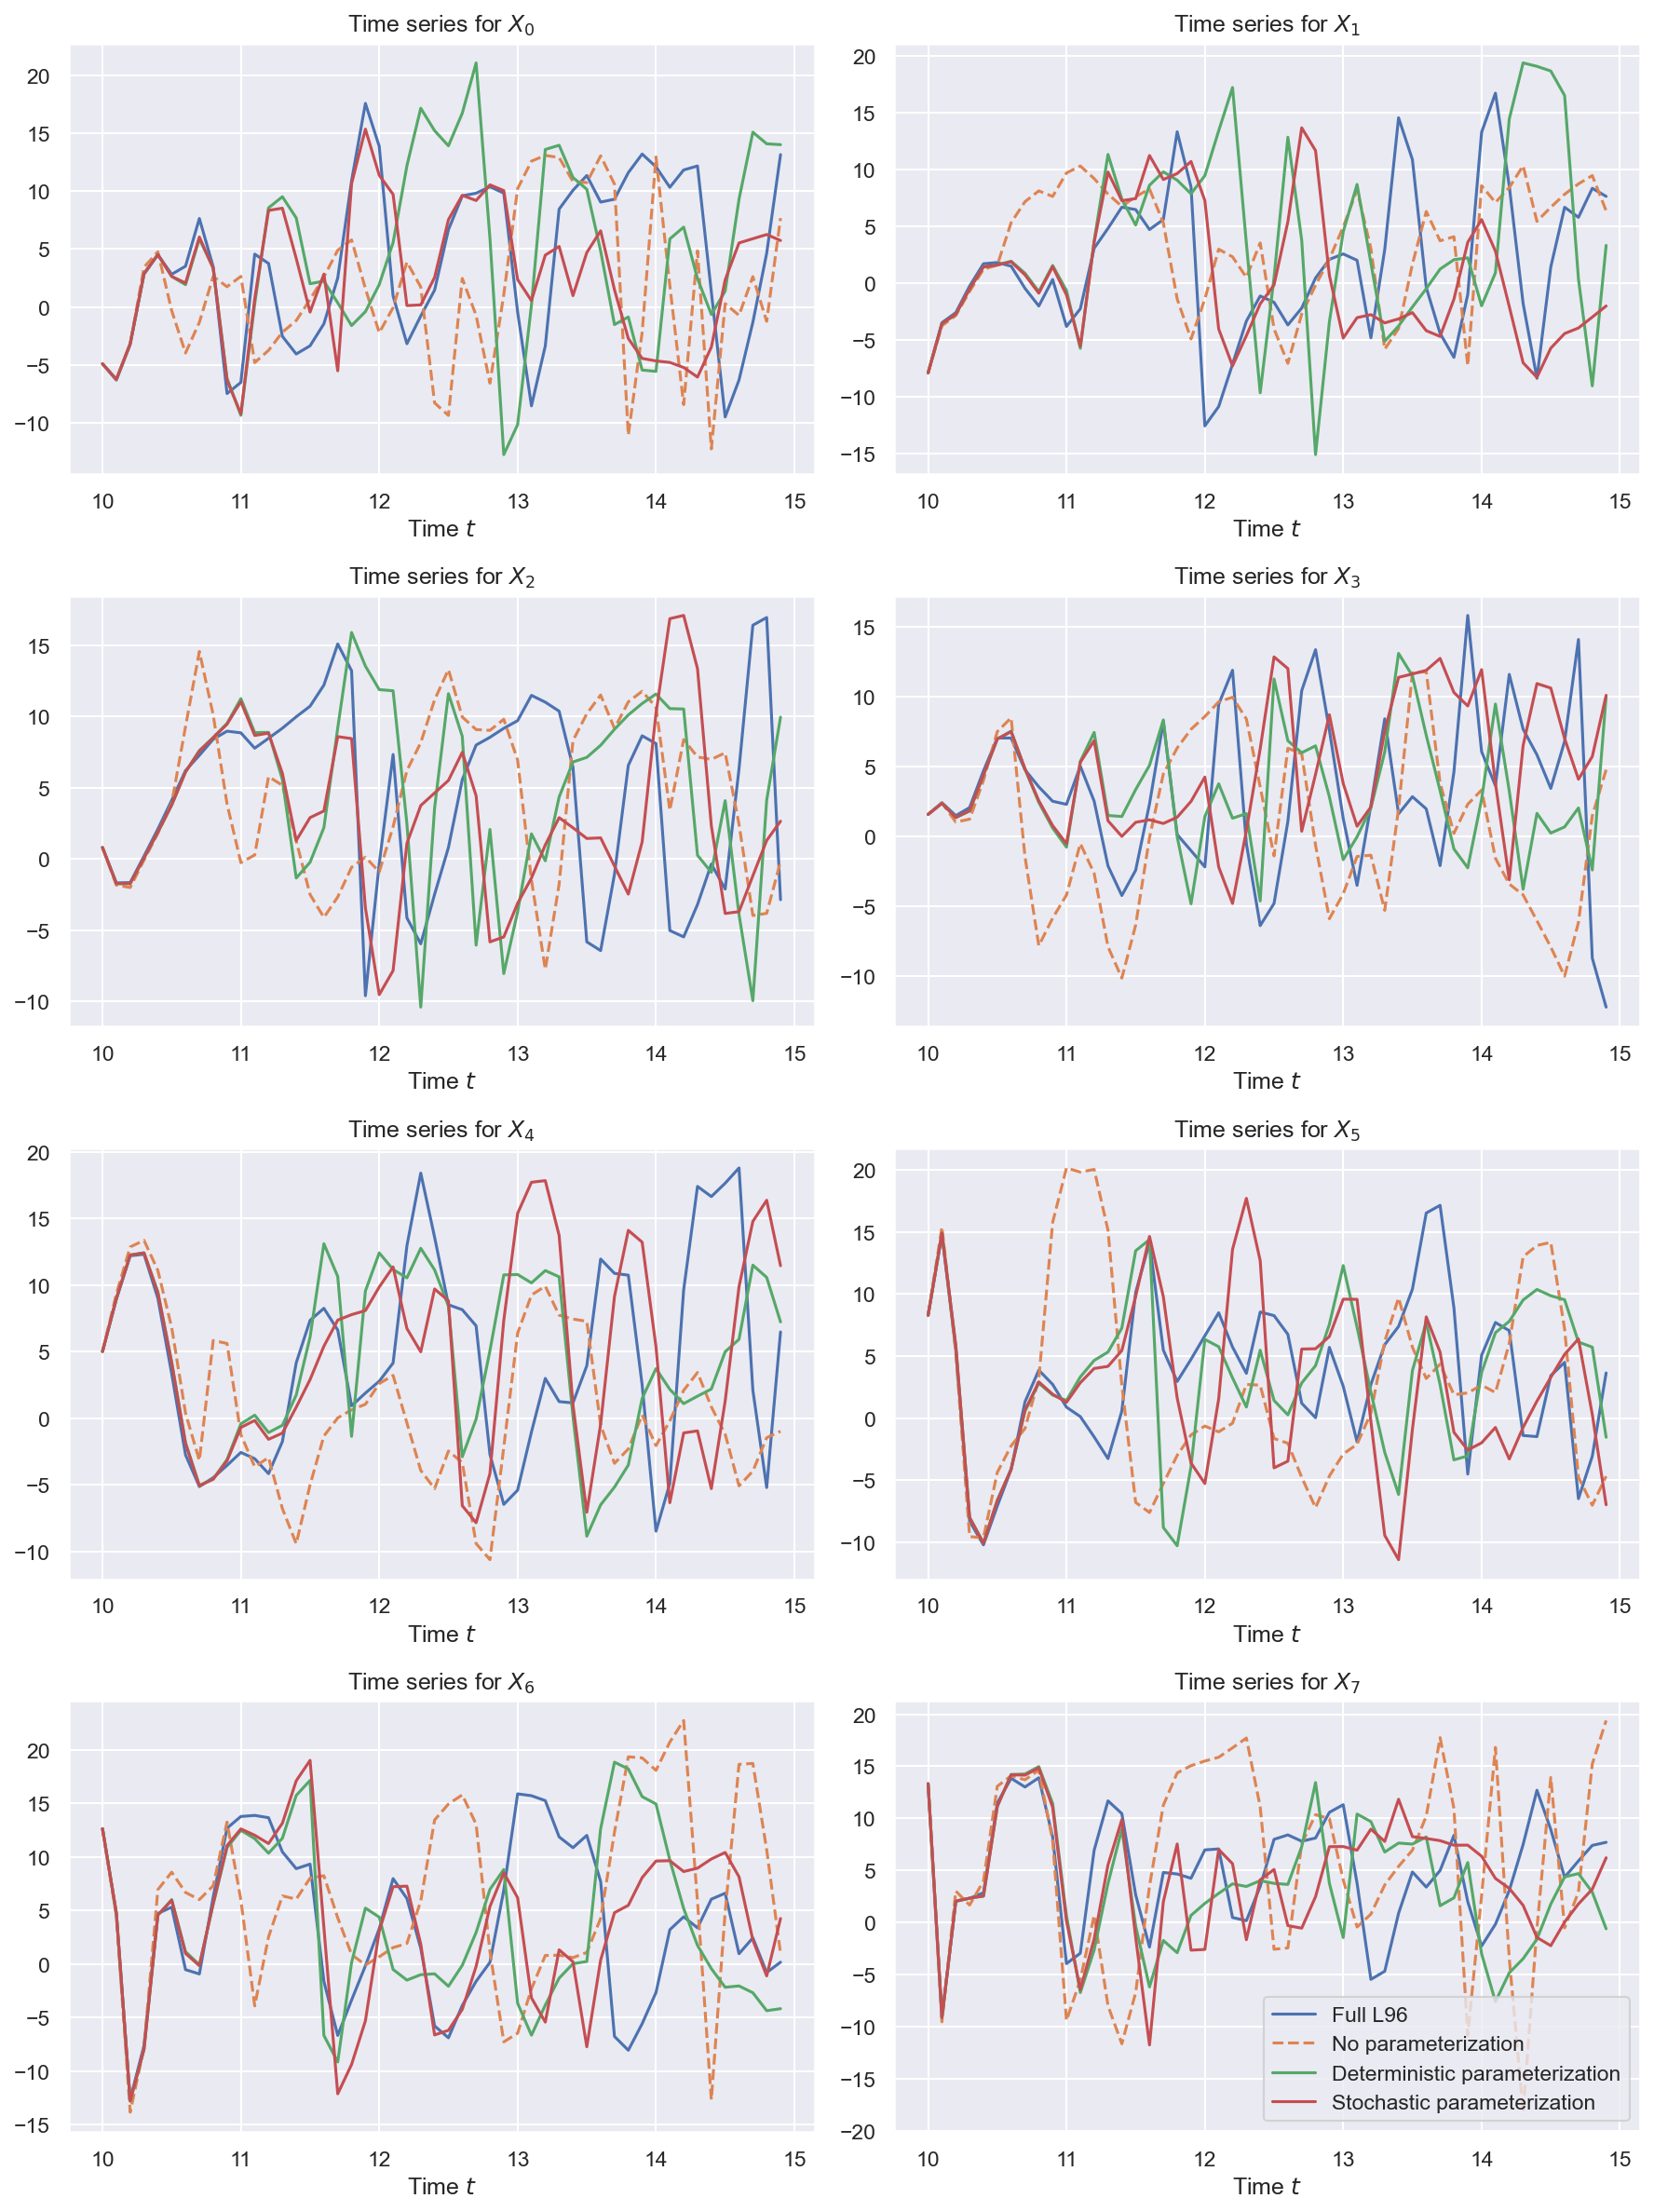

In [41]:
sns.set_theme()
time_i = 50

# plot each x_k
plt.figure(figsize=(12, FLAGS['K'] * 2), dpi=dpi)
for i in range(FLAGS['K']):
    subplot_index = int(f"{math.ceil(FLAGS['K']/2)}2{i+1}")
    plt.subplot(subplot_index)

    random_y_index = np.random.randint(0, FLAGS['J'])
    plt.plot(t[:time_i], x_true[:time_i, i], label=f"Full L96")
    plt.plot(t[:time_i], x_no_param[:time_i, i], '--', label=f"No parameterization")
    plt.plot(t[:time_i], x_det_param[:time_i, i], label=f"Deterministic parameterization")
    plt.plot(t[:time_i], x_stoch_param[:time_i, i], label=f"Stochastic parameterization")

    plt.xlabel("Time $t$")
    plt.title(f"Time series for $X_{i}$")
plt.legend()

plt.tight_layout()

if save_plots: 
    f_name = f"gcm_time_series_c{FLAGS['c']}_dt{FLAGS['dt']}_si{FLAGS['si']}_time{FLAGS['t_total']}_rs{FLAGS['seed']}.pdf"
    plt.savefig(os.path.join(figures_folder, f_name), format="pdf", bbox_inches="tight")

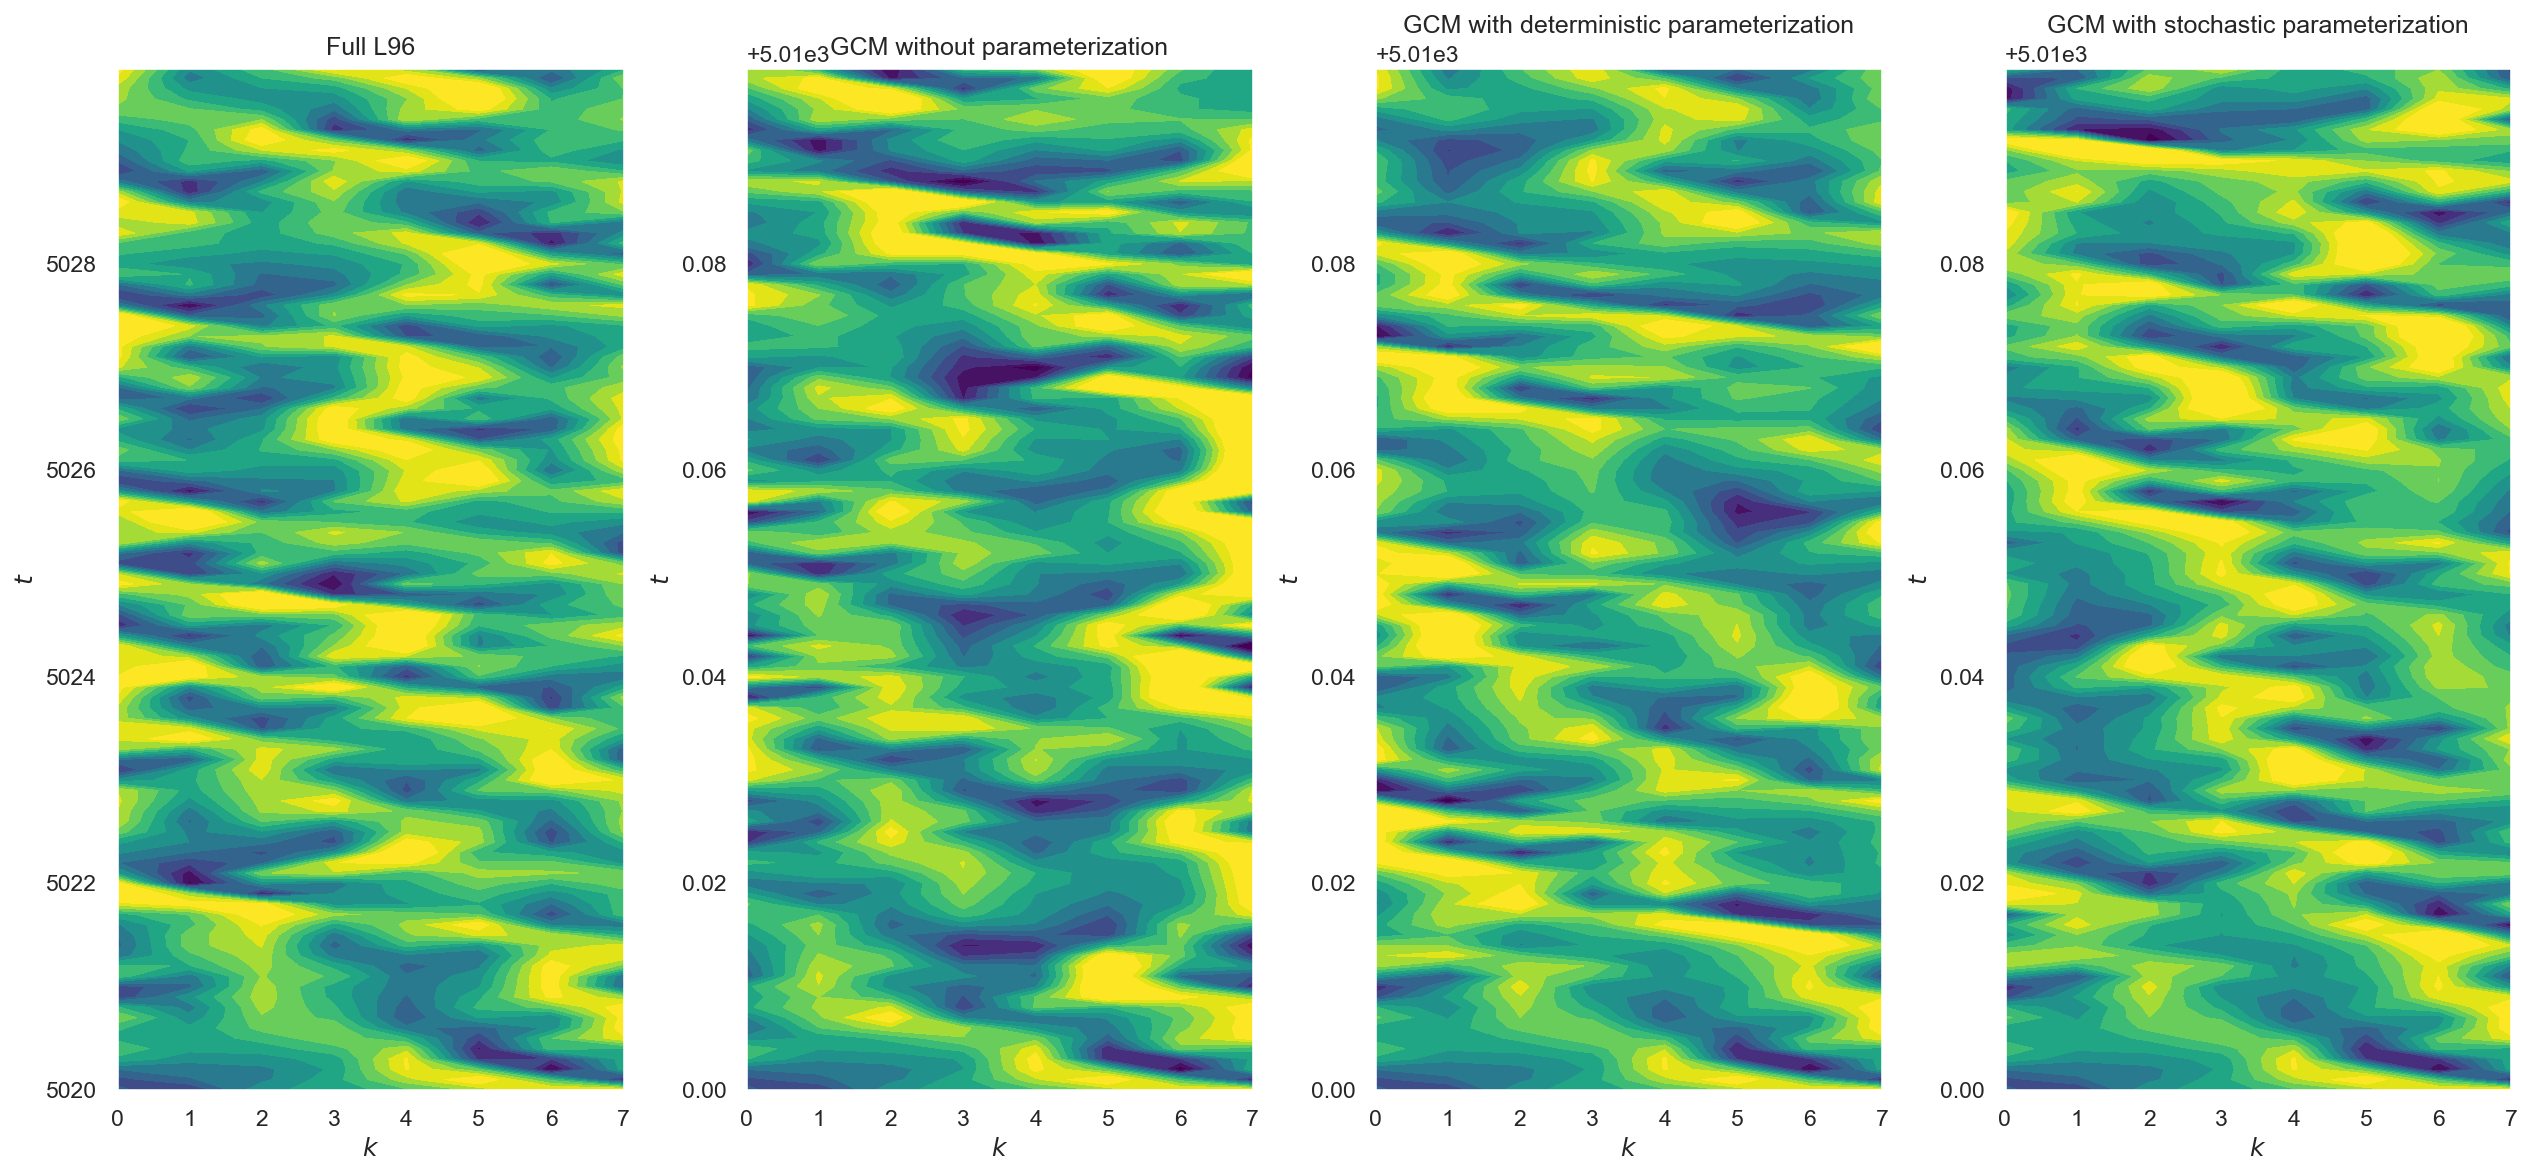

In [42]:
sns.set_theme()

cmap = 'viridis'

time_i = 100

plt.figure(dpi=dpi, figsize=(17, 8))
lims = {"vmin": -12, "vmax": 12,
        "levels": np.linspace(-12, 12, 12), "extend": "both"}

plt.subplot(141)
plt.contourf(m.range_k, (t + t[-1])[:time_i],
             x_true[:time_i, :], cmap=cmap, **lims)
plt.xlabel("$k$")
plt.ylabel("$t$")
plt.title("Full L96")

plt.subplot(142)
plt.contourf(m.range_k, (t_no_param + t[-1])
             [:time_i], x_no_param[:time_i, :], cmap=cmap, **lims)
plt.xlabel("$k$")
plt.ylabel("$t$")
plt.title("GCM without parameterization")

plt.subplot(143)
plt.contourf(m.range_k, (t_det_param + t[-1])
             [:time_i], x_det_param[:time_i, :], cmap=cmap, **lims)
plt.xlabel("$k$")
plt.ylabel("$t$")
plt.title("GCM with deterministic parameterization")

plt.subplot(144)
plt.contourf(m.range_k, (t_stoch_param +
             t[-1])[:time_i], x_stoch_param[:time_i, :], cmap=cmap, **lims)
plt.xlabel("$k$")
plt.ylabel("$t$")
plt.title("GCM with stochastic parameterization")

plt.tight_layout()

if save_plots:
    f_name = f"gcm_2d_comparison_c{FLAGS['c']}_dt{FLAGS['dt']}_si{FLAGS['si']}_time{FLAGS['t_total']}_rs{FLAGS['seed']}.pdf"
    plt.savefig(os.path.join(figures_folder, f_name),
                format="pdf", bbox_inches="tight")

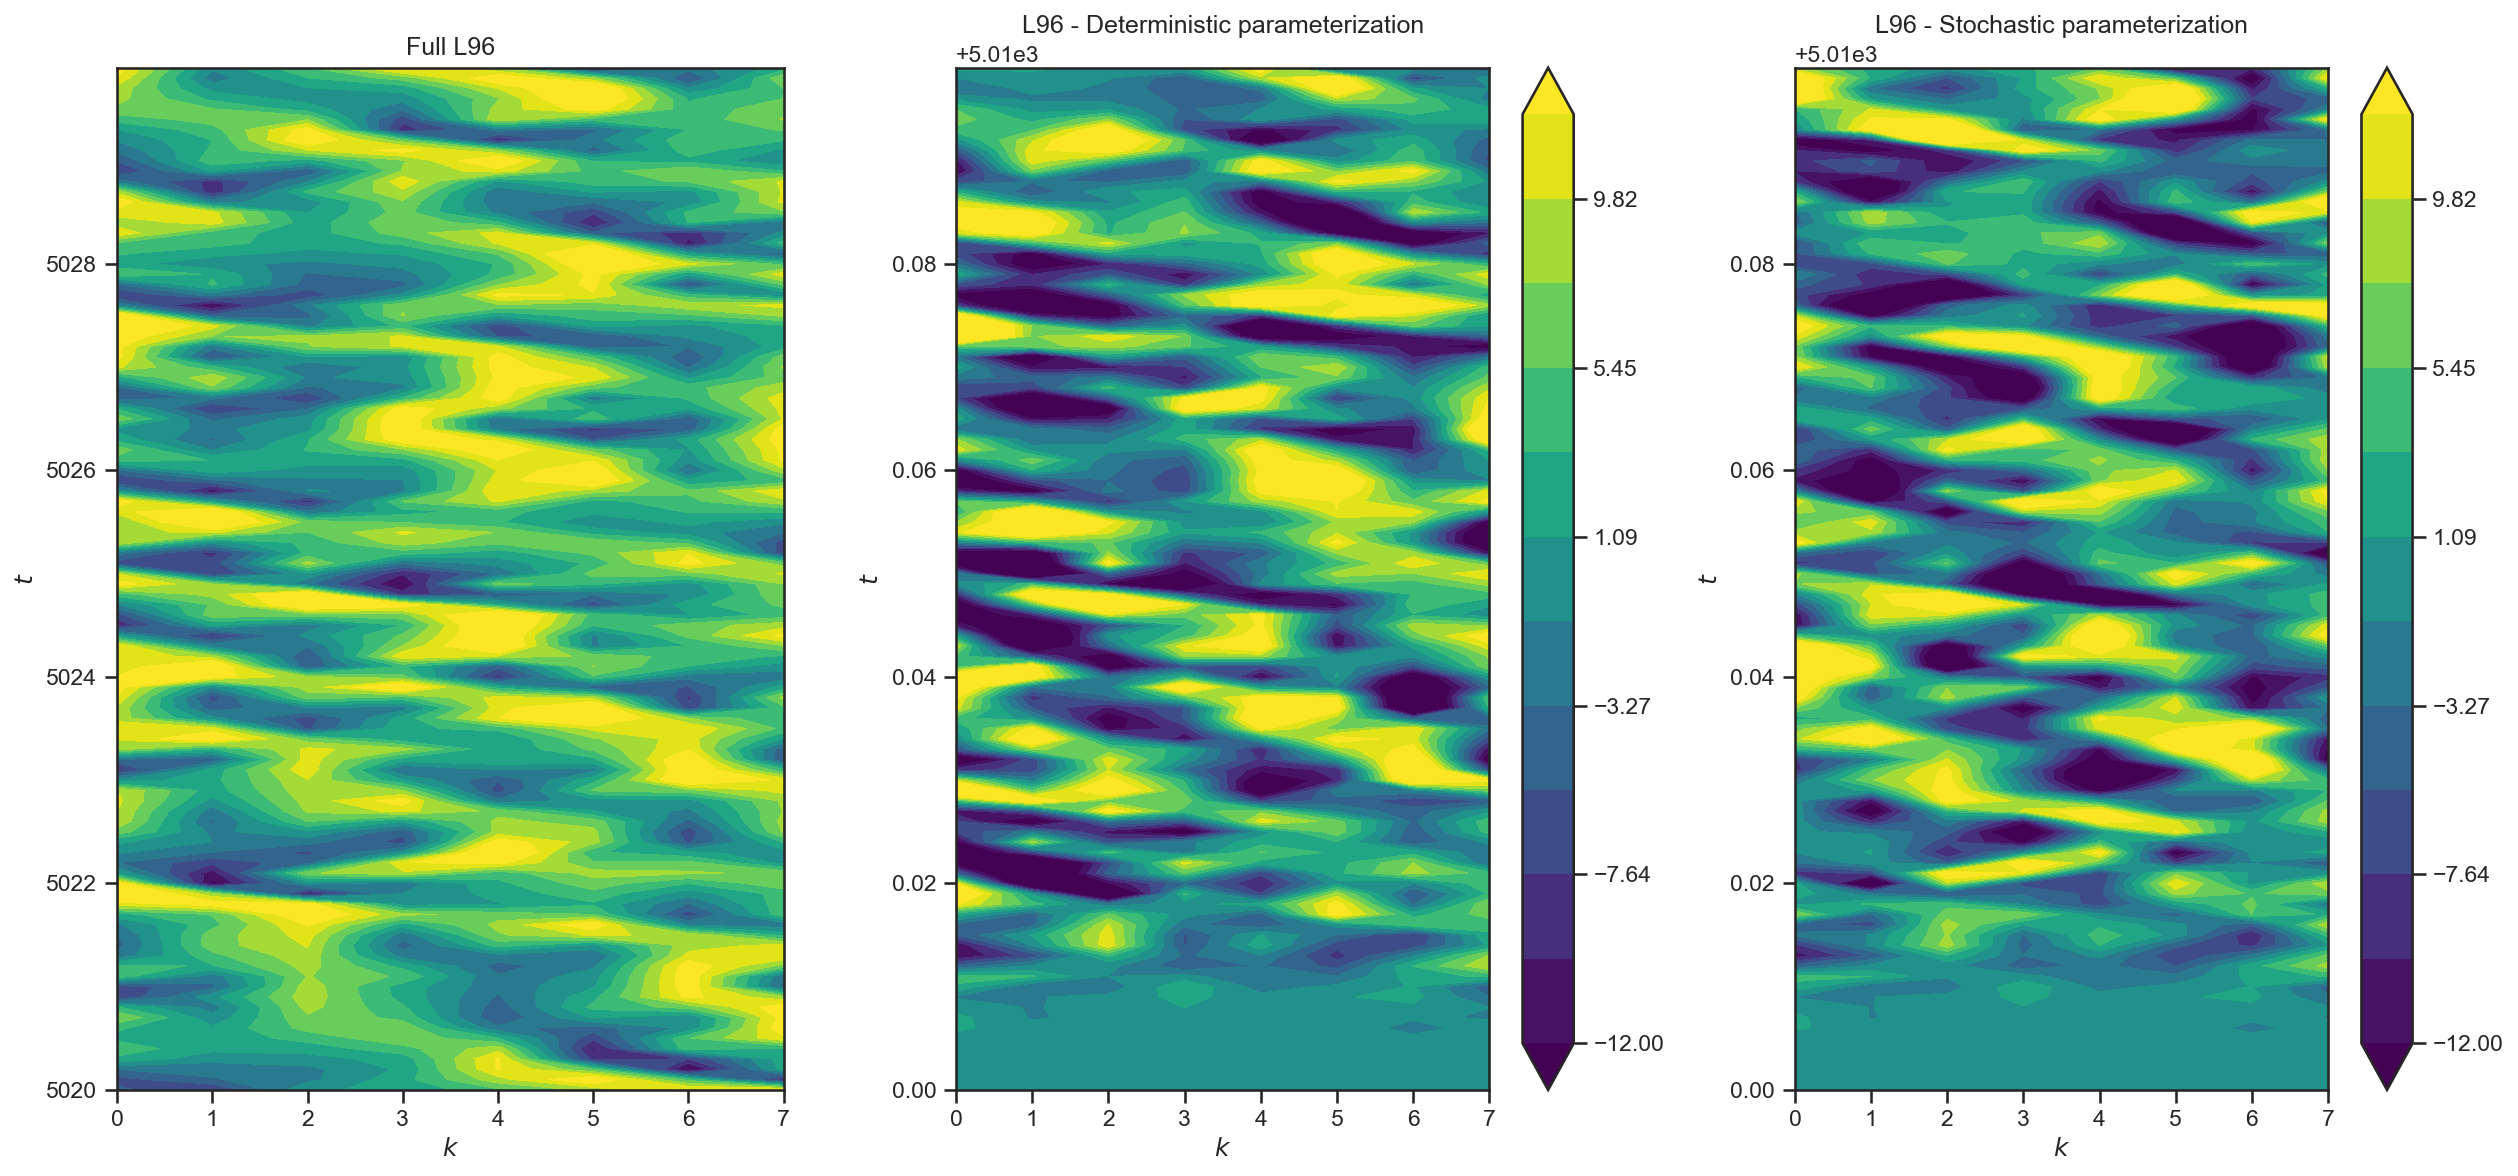

In [43]:
sns.set_theme(style='ticks')

cmap = 'viridis'

time_i = 100

plt.figure(dpi=dpi, figsize=(17, 8))
lims = {"vmin": -12, "vmax": 12,
        "levels": np.linspace(-12, 12, 12), "extend": "both"}

plt.subplot(131)
plt.contourf(m.range_k, (t + t[-1])[:time_i],
             x_true[:time_i, :], cmap=cmap, **lims)
plt.xlabel("$k$")
plt.ylabel("$t$")
plt.title("Full L96")

plt.subplot(132)
plt.contourf(m.range_k, (t_det_param + t[-1])
             [:time_i], x_true[:time_i, :] - x_det_param[:time_i, :], cmap=cmap, **lims)
plt.xlabel("$k$")
plt.ylabel("$t$")
plt.title("L96 - Deterministic parameterization")
plt.colorbar()


plt.subplot(133)
plt.contourf(m.range_k, (t_stoch_param +
             t[-1])[:time_i], x_true[:time_i, :] - x_stoch_param[:time_i, :], cmap=cmap, **lims)
plt.xlabel("$k$")
plt.ylabel("$t$")
plt.title("L96 - Stochastic parameterization")
plt.colorbar()


plt.tight_layout()

if save_plots:
    f_name = f"gcm_2d_difference_c{FLAGS['c']}_dt{FLAGS['dt']}_si{FLAGS['si']}_time{FLAGS['t_total']}_rs{FLAGS['seed']}.pdf"
    plt.savefig(os.path.join(figures_folder, f_name),
                format="pdf", bbox_inches="tight")

## Ensemble run

In [7]:
from ensemble.stochastic_poly_ensemble import run_stochastic_ensemble_parallel_multiprocessing, run_stochastic_member, run_stochastic_member_manual

In [76]:
# perturb initial states
perturb = True

### Multiple initial states, single stochastic model run per state

In [ ]:
FLAGS['t_total'] = 5000 
# Number of initial states
FLAGS['init_states'] = 50
# Time steps at which to select initial states
FLAGS['steps'] = 10
# Number of ensemble members
FLAGS['n_ens'] = 1

seeds = np.arange(0, FLAGS['init_states']*FLAGS['n_ens']+1, dtype=int)                         

%time x_stoch_ens, t_stoch_ens, init_indices = \
    run_stochastic_ensemble_parallel_multiprocessing(FLAGS['init_states'], FLAGS['n_ens'], FLAGS['steps'], \
        x_true, FLAGS['t_total'], FLAGS['F'], FLAGS['si'], FLAGS['K'], \
            run_stochastic_member_manual, seeds, perturb, p3_coefs, phi, sigma_e, FLAGS['dt'])

In [ ]:
save_output_ensemble(output_folder, FLAGS, 'stoch_param', x_stoch_ens, t_stoch_ens, init_indices, seeds)

In [47]:
n_init_states = FLAGS['init_states']

### Single initial state, multiple stochastic runs

In [48]:
FLAGS['t_total'] = 5000 
# Number of initial states
FLAGS['init_states'] = 1
# Time steps at which to select initial states
FLAGS['steps'] = 10
# Number of ensemble members
FLAGS['n_ens'] = 50


seeds = np.arange(0, FLAGS['init_states']*FLAGS['n_ens']+1, dtype=int)                         


%time x_stoch_ens, t_stoch_ens, init_indices = \
    run_stochastic_ensemble_parallel_multiprocessing(FLAGS['init_states'], FLAGS['n_ens'], FLAGS['steps'], \
        x_true, FLAGS['t_total'], FLAGS['F'], FLAGS['si'], FLAGS['K'], \
            run_stochastic_member_manual, seeds, perturb, p3_coefs, phi, sigma_e, FLAGS['dt'])

CPU times: user 134 ms, sys: 766 ms, total: 900 ms
Wall time: 39min 5s


In [49]:
save_output_ensemble(output_folder, FLAGS, 'stoch_param', x_stoch_ens, t_stoch_ens, init_indices, seeds)

In [50]:
n_ens = FLAGS['n_ens']

## L96 ensemble

In [8]:
from ensemble.l96_parallel_ensemble import run_l96_parallel

### Multiple initial states

In [78]:
FLAGS['t_total'] = 5000 
# Number of initial states
FLAGS['init_states'] = 50
# Time steps at which to select initial states
FLAGS['steps'] = 10
# Number of ensemble members
FLAGS['n_ens'] = 1

In [79]:
init_state_indices = np.arange(0, FLAGS['steps'] * FLAGS['init_states'], FLAGS['steps'], dtype=int)
len(init_state_indices)

50

#### Single seed

In [ ]:

rg = np.random.default_rng(seed=FLAGS['seed'])

l96_init_states = [(x_true[init_state_indices[i]] + rg.normal(0, 1, size=(FLAGS['K'],)),
                    y_true[init_state_indices[i]], t[init_state_indices[i]])
                   for i in range(n_init_states)]

x_per_state, y_per_state, t_per_state, u_per_state = run_l96_parallel(
    l96_init_states, FLAGS)


#### Multiple seeds

In [ ]:
seeds = np.arange(0, n_init_states+1, dtype=int)                         

rgs = [np.random.default_rng(seed=s) for s in seeds]

l96_init_states = [(x_true[init_state_indices[i]] + gen.normal(0, 1, size=(FLAGS['K'],)),
                    y_true[init_state_indices[i]], t[init_state_indices[i]])
                   for i, gen in zip(range(n_init_states), rgs)]

%time x_per_state, y_per_state, t_per_state, u_per_state = run_l96_parallel(l96_init_states, FLAGS)


CPU times: user 2.86 s, sys: 12.6 s, total: 15.5 s
Wall time: 23min 10s


In [ ]:
save_output_l96_ensemble_simulation(output_folder, FLAGS, x_per_state, y_per_state, t_per_state, u_per_state, seeds=seeds)

### Single initial state

In [80]:
FLAGS['t_total'] = 5000 
# Number of initial states
FLAGS['init_states'] = 1
# Time steps at which to select initial states
FLAGS['steps'] = 10
# Number of ensemble members
FLAGS['n_ens'] = 50

In [81]:
init_state_indices = np.arange(0, FLAGS['steps'] * FLAGS['init_states'], FLAGS['steps'], dtype=int)
len(init_state_indices)

1

#### Perturbed multiple times, L96 all same seed

In [ ]:
seeds = np.arange(0, n_ens+1, dtype=int)                         

rgs = [np.random.default_rng(seed=s) for s in seeds]

init_state_index = init_state_indices[0]

l96_init_states = [(x_true[init_state_index] + gen.normal(0, 1, size=(FLAGS['K'],)),
                    y_true[init_state_index], t[init_state_index])
                   for  gen in rgs]

%time x_per_state, y_per_state, t_per_state, u_per_state = run_l96_parallel(l96_init_states, FLAGS)

CPU times: user 2.95 s, sys: 13 s, total: 16 s
Wall time: 22min 34s


In [ ]:
save_output_l96_ensemble_simulation(output_folder, FLAGS, x_per_state, y_per_state, t_per_state, u_per_state, seeds=seeds)

### Perturbed once, but L96 with different seed

In [82]:
seeds = np.arange(0, n_ens+1, dtype=int)                         


init_state_index = init_state_indices[0] 
l96_init_states = [ (x_true[init_state_index] + np.random.default_rng(seed=FLAGS['seed']).normal(0, 1, size=(FLAGS['K'],)), y_true[init_state_index], t[init_state_index])]

%time x_per_state, y_per_state, t_per_state, u_per_state = run_l96_parallel(l96_init_states, FLAGS, seeds=seeds)

CPU times: user 2.86 s, sys: 11.8 s, total: 14.7 s
Wall time: 23min 52s


In [83]:
Path(os.path.join(output_folder, 'L96', 'different_model_seeds')).mkdir(parents=True, exist_ok=True)
save_output_l96_ensemble_simulation(os.path.join(output_folder, 'L96', 'different_model_seeds'),
                                    FLAGS, x_per_state, y_per_state, t_per_state, u_per_state, seeds=seeds)